# **S**pectroscopy of **L**iquids **U**sing **R**obot **P**erception 
# *(SLURP)* Data Analysis

### Author: Nathaniel Hanson
### Last Updated: 08/28/2022

In [29]:
# Main imports
import os
import csv

import typing
import os
import torch
import pickle as pk
from tqdm.notebook import tqdm
from torch import nn
from copy import deepcopy
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from datetime import datetime
from sklearn import preprocessing
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib
import numpy.matlib
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.tensorboard import SummaryWriter
from utils import SpectralData, train_epochs
from models import MLP, Simple1DCNN, FusedNet, ContNet
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
# Change default figure size depending on display
matplotlib.rcParams['figure.figsize'] = [10, 5]

### Part 0: Read in all spectrometer data

In [30]:
# Read in all data
read_files = os.listdir('new_data')
readings = {z.split('.')[0]:pd.read_csv(os.path.join('./new_data',z)) for z in read_files}
# Remove extra data fields from the readings
for key in readings.keys():
    try:
        # print(list(readings[key].columns)[:-4])
        readings[key] = readings[key].loc[:,list(readings[key].columns)[:-4]].to_numpy().astype(np.int32)
    except Exception as e:
        print(str(e))
    # print(readings[key].shape)

### Perform reflectance calibraiton across all data samples

In [31]:
# Read in calibration data
hamamatsu_dark = np.median(pd.read_csv('./calibration/hamamatsu_black_ref.csv').to_numpy().astype(np.int32), axis=0)
hamamatsu_white = np.median(pd.read_csv('./calibration/hamamatsu_white_ref.csv').to_numpy().astype(np.int32), axis=0)
mantispectra_dark = np.median(pd.read_csv('./calibration/mantispectra_black_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)
mantispectra_white = np.median(pd.read_csv('./calibration/mantispectra_white_ref.csv').to_numpy()[:,:-5].astype(np.int32), axis=0)

# Create composite calibration file
white_ref = np.concatenate((hamamatsu_white, mantispectra_white))[1:]
dark_ref = np.concatenate((hamamatsu_dark, mantispectra_dark))[1:]

# Create calibration function
def spectral_calibration(reading):
    t = np.divide((reading-dark_ref), (white_ref-dark_ref), where=(white_ref-dark_ref)!=0)
    # Handle cases where there is null division, which casts values as "None"
    if np.sum(t==None) > 0:
        print('Null readings!')
    t[t== None] = 0
    # Handle edge cases with large spikes in data, clip to be within a factor of the white reference to avoid skewing the model
    t = np.clip(t,-2.5,2.5)
    return t

### Reflectance normalize spectral readings

In [32]:
# Calibrate all the data
readings_cal = {}
for key in readings.keys():
    readings_cal[key] = np.apply_along_axis(spectral_calibration,1,readings[key])

### Read label data for each experiment

In [33]:
# Read in the container-substrate pairings
pairings = pd.read_csv('./container_substrate_v2.csv',header=1, keep_default_na=False)
# Remove blank data rows
pairings = pairings.loc[:18,(pairings.columns)[:20]]
# Unique substances
contents = list(pairings.columns[1:])
# display(pairings)

In [34]:
pairings

,container / substrate,Empty,Milk,Almond Milk,Vinegar,Orange Juice,Ketchup,Soy Sauce,Water,Sugar Water,Olive oil,Vegetable Oil,Liquid Soap,Tylenol (PM),Ibuprofen,Salt,Sugar,Flour,Coke
0,Silicone,A,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
1,Silicone,B,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,B16
2,Silicone,C,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16
3,PP,D,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16
4,PP,E,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16
5,PP,F,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16
6,PP,G,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,G15,G16
7,PP,H,H0,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,H13,H14,H15,H16
8,HDPE,I,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16
9,Acrylic,J,J0,J1,J2,J3,J4,J5,J6,J7,J8,J9,J10,J11,J12,J13,J14,J15,J16


In [35]:
np.random.default_rng().normal(1.0,0.05,1)[0]

1.0061634721036952

In [36]:
# Containers to exclude - wood, stainless steel, aluminum
exclude_containers = ['O','P','Q','I','K','M']
exclude_contents = [15,2,0,7,10,12]
# Generalized function to group data by the contents type

def random_scale(reading: np.array) -> np.array:
    return reading * np.random.default_rng().normal(1.0,0.05,1)[0]

def generate_data_labels(readings: Dict) -> defaultdict:
    data_by_contents = np.array([])
    labels_by_contents = np.array([])

    # Iterate over all data_frames types
    for key in readings.keys():
        # Iterate over all containers, but skip Aluminum (P), Stainless Steel (Q), and Wood (R)
        if key[0] in exclude_containers or (len(key) > 1 and int(key[1:]) in exclude_contents): #:or int(key[1:]) in exclude_contents:
            continue
        for index, val in enumerate(contents):
            if key not in list(pairings[val]):
                continue
            # Otherwise the data is useful to use, let's proceed with the data wrangling
            useData = readings[key]
            # ADD SCALING NOISE TO THE DATA HERE
            # useData = np.matlib.repmat(useData,4,1)
            # useData = np.apply_along_axis(random_scale,1,useData)
            # Get the plain name of the container
            useContainer = pairings[np.equal.outer(pairings.to_numpy(copy=True),  [key]).any(axis=1).all(axis=1)]['container / substrate'].iloc[0]
            # Add the index as the key value
            data_by_contents = np.vstack((data_by_contents, useData)) if data_by_contents.size else useData
            labels_by_contents = np.vstack((labels_by_contents, np.matlib.repmat([val,useContainer],useData.shape[0],1))) if labels_by_contents.size else np.matlib.repmat([val,useContainer],useData.shape[0],1)
    return data_by_contents, labels_by_contents


### Extract features from signals

In [54]:
def build_network(input_size: int, num_containers: int, num_contents: int, hidden_layers_l1: Tuple=(256,128), hidden_layers_l2: Tuple=(256,128)) -> Tuple[nn.Module,str]:
    '''
    Generate a train able neural network architecture
    
    Args: 
        architecture (str): Type of architecture to generate
        input_size (int): Number of input features
        classes (int): Number of output features (classes)
        hidden_layers (Tuple, optional): Size of sequential hidden layers to use in network construction
        
    Returns:
        nn.Module: Model architecture
    '''

    # find device to train on
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using {device} device')

    model = ContNet(input_size, num_containers, num_contents, hidden_layers_l1, hidden_layers_l2)
    
    return model, device

def train_val_test_split(all_data: np.ndarray, targets: np.ndarray) -> Tuple[DataLoader, DataLoader, DataLoader]:
    '''
    Create train-test-val split from model data
    
    Args: 
        all_data (np.ndarray): 2D matrix of data to analyze
        targets (list): Numerical categorical labels for each row of data
        
    Returns:
        Tuple[DataLoader,DataLoader,DataLoader]: Train dataloader; validation dataloader; test dataloader
    '''
    X_train, X_test, y_train, y_test = train_test_split(all_data.astype(np.double), targets, test_size=0.10, stratify=targets)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) # 0.25 x 0.8 = 0.2
    train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.LongTensor)) # Main train set
    valid_dataset = TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val).type(torch.LongTensor))  # Validation set
    test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.LongTensor))  # Test set
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
    return train_loader, val_loader, test_loader

def train_val_test_split_cross(all_data: np.ndarray, targets: np.ndarray) -> Tuple[TensorDataset, TensorDataset, DataLoader]:
    '''
    Create train-test-val split from model data for cross validation model training
    
    Args: 
        all_data (np.ndarray): 2D matrix of data to analyze
        targets (list): Numerical categorical labels for each row of data
        
    Returns:
        Tuple[TensorDataset,TensorDataset,DataLoader]: Train dataset; validation dataset; test dataloader
    '''
    X_train, X_test, y_train, y_test = train_test_split(all_data.astype(np.double), targets, test_size=0.2, stratify=targets)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train) # 0.25 x 0.8 = 0.2
    train_dataset = TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train).type(torch.LongTensor)) # Main train set
    valid_dataset = TensorDataset(torch.Tensor(X_val),torch.Tensor(y_val).type(torch.LongTensor))  # Validation set
    test_dataset = TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test).type(torch.LongTensor))  # Test set
    test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
    return train_dataset, valid_dataset, test_loader

def reset_weights(m: nn.Module):
    '''
    Try resetting model weights to avoid weight leakage  
    
    Args:
        model (nn.Module): Network to reset weight on
        
    Returns:
        None
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


        
def train_model(model: nn.Module, architecture: str, train_loader: DataLoader, val_loader: DataLoader, epochs: int, device: str, save_prefix: str, trials=1, mean=0, sigma=0.05) -> Tuple[nn.Module, List, List, List]:
    '''
    Training routine for models
    
    Args:
        model (nn.Module): Network to train
        architecture (str): Model type to run
        train_loader (DataLoader): Object to load training data and labels
        val_loader (DataLoader): Object to load validation data and labels
        epochs (int): Number of epochs to train each model for
        device (str): Location to execute computations over
        save_prefix (str): Prefix to use when saving model files
        trials (int, optional): Number of times to run and average model over
        mean (float, optional): Mean to use for injecting gaussian noise into training
        sigma (float, optional): Variance to use for injecting gaussian noise into training
        
    Returns:
        Tuple[nn.Module, List, List, List]: Best modle trained; training loss; validation loss; validation accuracy
    '''
    models = []
    train_loss_all = []
    val_loss_all = []
    val_accuracy_all = []
    for trial in tqdm(range(trials), desc='Trial:', position=0):
        reset_weights(model)
        train_loss = []
        val_loss = []
        val_accuracy = []
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        best_acc = 0
        for epoch in tqdm(range(epochs), desc='Epoch', position=1 ,leave=False):
            model.train()
            running_loss = 0
            last_loss = 0
            total_correct = 0
            running_loss_train = 0
            for i, data in enumerate(train_loader):
                inputs, true_labels = data[0], data[1].to(device)
                inputs = inputs + torch.randn(*inputs.shape)*sigma+mean
                inputs = inputs.to(device)
                optimizer.zero_grad()

                outputs = model(inputs.double())
                loss = loss_fn(outputs, true_labels)
                loss.backward()
                optimizer.step()

                running_loss_train += loss.item()

                # calculate accuracy
                pred_labels = torch.argmax(outputs, dim=1, keepdim=False)
                # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                correct = (pred_labels == true_labels).float().sum()
                total_correct += correct

                if i % 10 == 9:
                    last_loss = running_loss_train / 10

            # Keep track of train loss
            train_loss.append(last_loss)

            model.train(False)
            running_loss_val = 0.0
            correct = 0
            cum_samples = 0
            for i, val_data in enumerate(val_loader):
                inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
                cum_samples += len(true_labels) 
                # calculate loss
                output = model(inputs.double())
                loss = loss_fn(output, true_labels)
                running_loss_val += loss.item()

                # calculate accuracy
                pred_labels = torch.argmax(output, dim=1, keepdim=False)
                # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
                correct += (pred_labels == true_labels).float().sum()

            avg_val_loss = running_loss_val / (i + 1)
            val_loss.append(avg_val_loss)
            if correct.cpu()/cum_samples > best_acc:
                best_acc = correct.cpu()/cum_samples
                torch.save(model.state_dict(), f'./weights/{save_prefix}__{architecture}_best.wts')
            
            val_accuracy.append(correct.cpu()/cum_samples)
    # Copy over the model
    models.append(model)
    train_loss_all.append(deepcopy(train_loss))
    val_loss_all.append(deepcopy(val_loss))
    val_accuracy_all.append(deepcopy(val_accuracy))
    
    return model, np.mean(train_loss_all,axis=0), np.mean(val_loss_all,axis=0), np.mean(val_accuracy_all,axis=0)

def test_accuracy(model: nn.Module, test_loader: DataLoader, device: str, le: preprocessing.LabelEncoder, prefix: str) -> None:
    '''
    Calculate test accuracy using held-out dataset
    Args: 
        model (nn.Module): Model architecture to pass data through
        test_loader (DataLoader): PyTorch dataloader with references to test data
        device (str): Location to execute computations over
        le (preproccessing.LabelEncoder): Object used to translate string labels into numeric indicies
        prefix (str): Prefix to use when saving model files
        
    Returns:
        None
    '''
    # Evaluate model on held out test set
    model.train(False)
    test_accuracy = []
    running_loss_val = 0.0
    correct = 0
    cum_samples = 0
    all_true = []
    all_preds = []
    for i, val_data in enumerate(test_loader):
        inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
        all_true.extend(list(true_labels.cpu()))
        cum_samples += len(true_labels) 
        # calculate loss
        output = model(inputs.double())

        # calculate accuracy
        pred_labels = torch.argmax(output, dim=1, keepdim=False)
        all_preds.extend(list(pred_labels.cpu()))
        # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
        correct += (pred_labels == true_labels).float().sum()

    print(f'Heldout Test Accuracy: {correct.cpu()/cum_samples}')
    disp = ConfusionMatrixDisplay.from_predictions(le.inverse_transform(all_true), le.inverse_transform(all_preds), normalize='true')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.title('Full Data Confusion Matrix')
    plt.savefig(f"./figs/{prefix}_confusion_matrix.png")
    plt.show()
    
    
def plot_train_results(train_loss: List, val_loss: List, val_accuracy: List, prefix: str, descriptor: str) -> None:
    '''
    Plots loss and accuracy results from training a model
    
    Args: 
        train_loss (list): Numerical data for training loss as a function of epoch
        val_loss (list): Numerical data for validation loss as a function of epoch
        val_accuracy (list): Numerical data for validation accuracy over training
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        
    Returns:
        None
    '''
    # View training results
    plt.figure(1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train loss")
    plt.plot(range(1, len(train_loss) + 1), val_loss, label="Val loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.title(f"{descriptor} - Train & Validation Loss")
    plt.savefig(f"./figs/{prefix}_train_val_loss.png")
    plt.show()
    # Accuracy
    plt.figure(2)
    plt.plot(range(1, len(val_accuracy) + 1), np.array(val_accuracy) * 100, label="Val accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy %")
    plt.title(f"{descriptor} - Spectral Validation Accuracy")
    plt.grid()
    plt.savefig(f"./figs/{prefix}_spectral_val_acc.png")
    plt.show()
    
def model_master(architecture: str, all_data: np.ndarray, labels: list, epochs: int, prefix: str, descriptor: str, trials=10, sigma=0.01, hidden_layers=(256,128)):
    '''
    Main function used to train spectroscopy models
    
    Args: 
        architecture (str): Model type to run
        all_data (np.ndarray): 2D matrix of data to analyze
        labels (list): Numerical categorical labels for each row of data
        epochs (int): Number of epochs to train each model for
        prefix (str): Prefix to use when saving model files
        descriptor (str): Title descriptor for displaying with figures
        trials (int, optional): Number of times to run and average model over
        sigma (float, optional): Sigma for Gaussian noise process to inject while training
        hidden_layers (Tuple, optional): Size of sequential hidden layers to use in network construction
        
    Returns:
        None
    '''
    # Create model architecture
    model, device = build_network(architecture, all_data.shape[1],len(np.unique(labels)),hidden_layers=hidden_layers)
    # Fit labels to model
    le = preprocessing.LabelEncoder()
    targets = le.fit_transform(labels)
    np.save(f'./weights/label_encoder_class_{prefix}.npy', le.classes_)
    # Create data splits
    train_loader, val_loader, test_loader = train_val_test_split(all_data,targets)
    # Train model given parameters
    model, train_loss, val_loss, val_accuracy = train_model(model, architecture, train_loader, val_loader, epochs, device, prefix, trials=trials, sigma=sigma)
    model.load_state_dict(torch.load(f'./weights/{prefix}__{architecture}_best.wts'))
    model.to(device)
    # Plot training results
    plot_train_results(train_loss, val_loss, val_accuracy, prefix, descriptor)
    # Calculate model statistics
    test_accuracy(model, test_loader, device, le, prefix)

In [55]:
all_data, labels = generate_data_labels(readings_cal)

In [56]:
all_data = np.hstack((all_data,np.gradient(all_data,axis=1)))

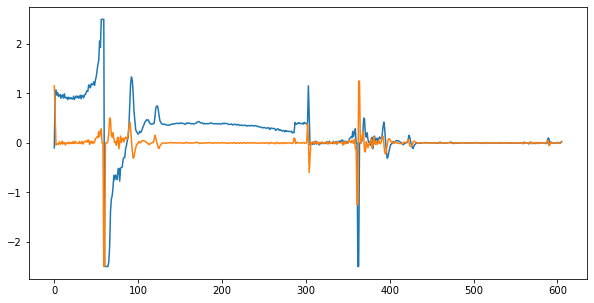

In [57]:
plt.plot(all_data[0,:])
plt.plot(np.gradient(all_data,axis=1)[0,:])

In [58]:
# Fit labels to model
le_contents = preprocessing.LabelEncoder()
le_containers = preprocessing.LabelEncoder()
labels_contents = le_contents.fit_transform(labels[:,0])
labels_containers = le_containers.fit_transform(labels[:,1])
encoded_labels = np.vstack((labels_containers,labels_contents)).T

In [59]:
np.unique(labels[:,1])

array(['Acrylic', 'Glass', 'PET', 'PP', 'Paper', 'Silicone'], dtype='<U13')

In [60]:
np.unique(labels[:,0])

array(['Almond Milk', 'Coke', 'Empty', 'Ketchup', 'Olive oil',
       'Orange Juice', 'Salt', 'Soy Sauce', 'Sugar', 'Tylenol (PM)',
       'Vegetable Oil', 'Water'], dtype='<U13')

In [61]:
all_data.shape

(4320, 606)

In [62]:
all_data = all_data

In [63]:
model,device = build_network(all_data.shape[1], len(np.unique(labels_containers)), len(np.unique(labels_contents)), hidden_layers_l1=(200,100,50), hidden_layers_l2=(200,100,50))

Using cuda device


In [64]:
train_loader,val_loader,test_loader = train_val_test_split(all_data, encoded_labels)
container_loss_fn = nn.CrossEntropyLoss()
contents_loss_fn = nn.CrossEntropyLoss()
epochs = 500
trials = 1
best_acc = 0
print(device)
container_running_loss = []
content_running_loss = []
total_loss = []
val_loss = []
val_content_accuracy = []
val_container_accuracy = []
val_total_accuracy = []
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for trial in tqdm(range(trials), desc='Trial', position=0):
    reset_weights(model)
    for epoch in tqdm(range(epochs), desc='Epoch', position=1 ,leave=False):
        model.train()
        running_loss = 0
        last_loss = 0
        total_correct = 0
        running_loss_train = 0
        running_loss_container = 0
        running_loss_content = 0
        for i, data in enumerate(train_loader):
            inputs, true_labels = data[0].to(device), data[1].to(device)
            #inputs = inputs.to(device)
            #true_labels = true_labels.to(device)
            optimizer.zero_grad()

            container_out, content_out = model(inputs)
            # Calculate the loss on containers
            container_loss = container_loss_fn(container_out, true_labels[:,0])
            # Calculate the loss on contets
            content_loss = contents_loss_fn(content_out, true_labels[:,1])
            # Add the loss functions
            loss = container_loss + content_loss
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            running_loss_container += container_loss.item()
            running_loss_content += content_loss.item()
            # calculate accuracy
            # pred_labels = torch.argmax(outputs, dim=1, keepdim=False)
            # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
            # correct = (pred_labels == true_labels).float().sum()
            # total_correct += correct

            if i % 10 == 9:
                last_loss = running_loss_train / 10
                last_container_loss = running_loss_container / 10
                last_content_loss = running_loss_content / 10

        # Keep track of train loss
        total_loss.append(last_loss)
        content_running_loss.append(last_content_loss)
        container_running_loss.append(last_container_loss)

        model.train(False)
        running_loss_val = 0.0
        correct_containers = 0
        correct_contents = 0
        correct_total = 0
        cum_samples = 0
        for i, val_data in enumerate(val_loader):
            inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
            cum_samples += len(true_labels) 
            # calculate loss
            container_out, content_out = model(inputs)
            # Calculate the loss on containers
            container_loss = container_loss_fn(container_out, true_labels[:,0])
            # Calculate the loss on contets
            content_loss = contents_loss_fn(content_out, true_labels[:,1])
            loss = container_loss + content_loss

            running_loss_val += loss.item()

            # calculate accuracy
            pred_containers = torch.argmax(container_out, dim=1, keepdim=False)
            pred_contents = torch.argmax(content_out, dim=1, keepdim=False)

            correct_containers += (pred_containers == true_labels[:,0]).float().sum()
            correct_contents += (pred_contents == true_labels[:,1]).float().sum()
            correct_total += torch.logical_and(pred_contents == true_labels[:,1], pred_containers == true_labels[:,0]).float().sum()

        avg_val_loss = running_loss_val / (i + 1)
        val_loss.append(avg_val_loss)
        if correct_total.cpu()/cum_samples > best_acc:
            best_acc = correct_total.cpu()/cum_samples
            torch.save(model.state_dict(), f'./weights/cont_net_best_hama.wts')

        val_content_accuracy.append(correct_contents.cpu()/cum_samples)
        val_container_accuracy.append(correct_containers.cpu()/cum_samples)
        val_total_accuracy.append(correct_total.cpu()/cum_samples)

cuda


Trial:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

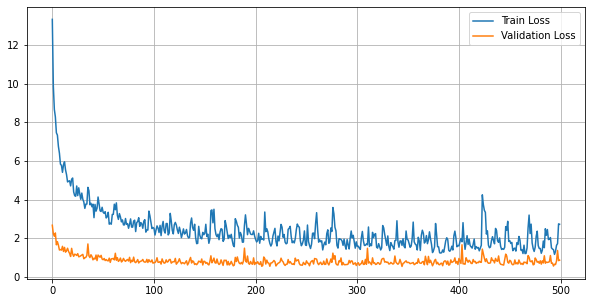

In [65]:
plt.plot(np.array(total_loss).reshape(trials,epochs).mean(axis=0),label='Train Loss')
plt.plot(np.array(val_loss).reshape(trials,epochs).mean(axis=0),label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

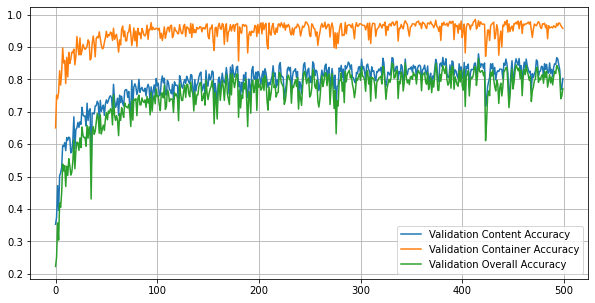

In [66]:
plt.plot(np.array(val_content_accuracy).reshape(trials,epochs).mean(axis=0),label='Validation Content Accuracy')
plt.plot(np.array(val_container_accuracy).reshape(trials,epochs).mean(axis=0),label='Validation Container Accuracy')
plt.plot(np.array(val_total_accuracy).reshape(trials,epochs).mean(axis=0),label='Validation Overall Accuracy')
plt.grid()
plt.legend()
plt.show()

Heldout Test Accuracy Containers: 0.9421296119689941
Heldout Test Accuracy Contents: 0.8055555820465088
Heldout Test Accuracy Overall: 0.7592592835426331


<Figure size 720x360 with 0 Axes>

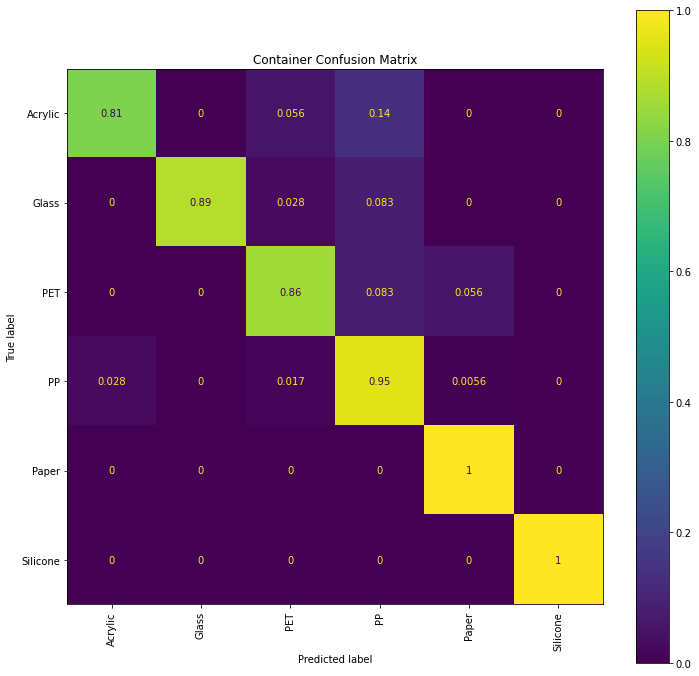

<Figure size 720x360 with 0 Axes>

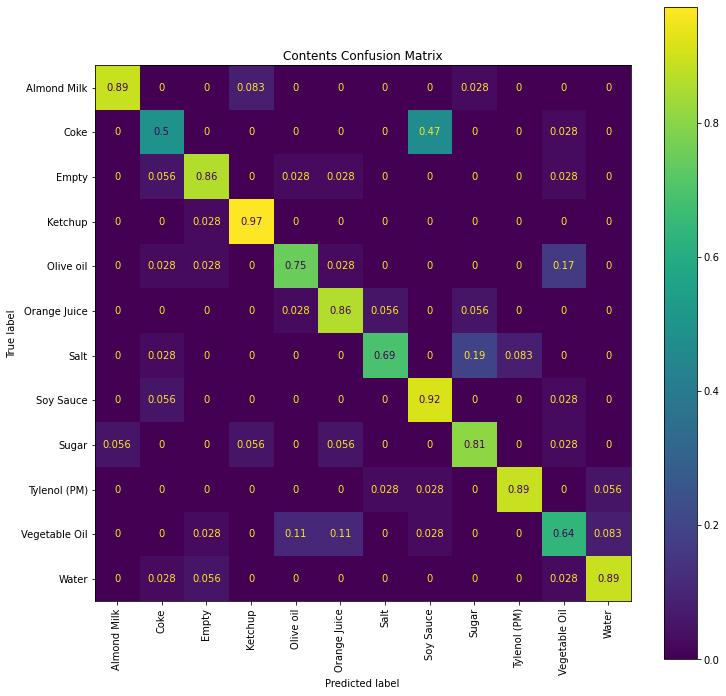

In [67]:
# Evaluate model on held out test set
#model.load_state_dict(torch.load(f'./weights/cont_net_best.wts'))
model.to(device)
model.train(False)
correct_contents = 0
correct_containers = 0
correct_total = 0
cum_samples = 0
all_true = []
all_preds_content = []
all_preds_container = []
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        inputs, true_labels = val_data[0].to(device), val_data[1].to(device)
        all_true.extend(true_labels.cpu().numpy())
        cum_samples += len(true_labels) 
        # calculate loss
        container_out, content_out = model(inputs)

        # calculate accuracy
        pred_containers = torch.argmax(container_out, dim=1, keepdim=False)
        pred_contents = torch.argmax(content_out, dim=1, keepdim=False)
        all_preds_content.extend(list(pred_contents.cpu()))
        all_preds_container.extend(list(pred_containers.cpu()))
        # true_labels = torch.argmax(true_labels, dim=1, keepdim=False)
        correct_containers += (pred_containers == true_labels[:,0]).float().sum()
        correct_contents += (pred_contents == true_labels[:,1]).float().sum()
        correct_total += torch.logical_and(pred_contents == true_labels[:,1], pred_containers == true_labels[:,0]).float().sum()

    print(f'Heldout Test Accuracy Containers: {correct_containers.cpu()/cum_samples}')
    print(f'Heldout Test Accuracy Contents: {correct_contents.cpu()/cum_samples}')
    print(f'Heldout Test Accuracy Overall: {correct_total.cpu()/cum_samples}')

all_true = np.array(all_true)
plt.figure()
disp = ConfusionMatrixDisplay.from_predictions(le_containers.inverse_transform(all_true[:,0]), le_containers.inverse_transform(all_preds_container), normalize='true')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('Container Confusion Matrix')
plt.savefig(f"./figs/all_containers_confusion_matrix.png")
plt.show()

plt.figure()
disp = ConfusionMatrixDisplay.from_predictions(le_contents.inverse_transform(all_true[:,1]), le_contents.inverse_transform(all_preds_content), normalize='true')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
fig = disp.ax_.get_figure() 
fig.set_figwidth(12)
fig.set_figheight(12)
plt.title('Contents Confusion Matrix')
plt.savefig(f"./figs/all_contents_confusion_matrix.png")
plt.show()

In [68]:
# Create calibration function
def spectral_calibration(reading):
    t = np.divide((reading-dark_ref), (white_ref-dark_ref), where=(white_ref-dark_ref)!=0)
    # Handle cases where there is null division, which casts values as "None"
    if np.sum(t==None) > 0:
        print('Null readings!')
    t[t== None] = 0
    # Handle edge cases with large spikes in data, clip to be within a factor of the white reference to avoid skewing the model
    t = np.clip(t,-2,2)
    return t

m = nn.Softmax(dim=1)
# Create a dummy array here
def eval_single(model: nn.Module, data: torch.tensor, device: str) -> None:
    '''
    Calculate test accuracy using held-out dataset
    Args: 
        model (nn.Module): Model architecture to pass data through
        test_loader (DataLoader): PyTorch dataloader with references to test data
        device (str): Location to execute computations over
        le (preproccessing.LabelEncoder): Object used to translate string labels into numeric indicies        
    Returns:
        None
    '''
    # Evaluate model on held out test set
    model.train(False)
    with torch.no_grad():
        inputs = data.to(device)
        container_out, content_out = model(inputs)

        # calculate accuracy
        pred_containers = torch.argmax(container_out, dim=1, keepdim=False).cpu()
        pred_contents = torch.argmax(content_out, dim=1, keepdim=False).cpu()
        print(sorted(zip(le_containers.classes_,m(container_out).cpu().numpy()[0,:]), key=lambda x: x[1], reverse=True)[:3])
        print(f'Predicted Container Class: {le_containers.inverse_transform(pred_containers)}')
        print(sorted(zip(le_contents.classes_,m(content_out).cpu().numpy()[0,:]), key=lambda x: x[1], reverse=True)[:3])
        print(f'Predicted Contents Class: {le_contents.inverse_transform(pred_contents)}')

i = 1
for f in os.listdir('./demo_data'):
    print(i)
    print(f.split('_')[0])
    data = spectral_calibration(np.load(f'./demo_data/{f}')[:,1:])
    print(data.shape)
    data = torch.Tensor(np.hstack((data,np.gradient(data,axis=1))))
    eval_single(model,data,'cuda')
    print('=================================')
    i+=1

1
A14
(1, 303)
[('Silicone', 0.9907953), ('PP', 0.0031192235), ('Acrylic', 0.002423597)]
Predicted Container Class: ['Silicone']
[('Salt', 0.99507856), ('Sugar', 0.0049091834), ('Tylenol (PM)', 1.047042e-05)]
Predicted Contents Class: ['Salt']
2
E3
(1, 303)
[('Silicone', 0.97190416), ('PP', 0.010556682), ('Acrylic', 0.0061944914)]
Predicted Container Class: ['Silicone']
[('Orange Juice', 0.9993438), ('Soy Sauce', 0.00029450658), ('Olive oil', 0.00025375903)]
Predicted Contents Class: ['Orange Juice']
3
G13
(1, 303)
[('PP', 0.99542916), ('Acrylic', 0.0045708735), ('Silicone', 1.2983974e-09)]
Predicted Container Class: ['PP']
[('Tylenol (PM)', 1.0), ('Almond Milk', 0.0), ('Coke', 0.0)]
Predicted Contents Class: ['Tylenol (PM)']
4
G14
(1, 303)
[('PP', 0.9942942), ('Glass', 0.0017842326), ('Acrylic', 0.0014518558)]
Predicted Container Class: ['PP']
[('Sugar', 0.9287069), ('Tylenol (PM)', 0.047207247), ('Almond Milk', 0.01786472)]
Predicted Contents Class: ['Sugar']
5
G15
(1, 303)
[('PP', 0

In [ ]:
np.load(f'./demo_data/{f}').shape

In [ ]:
len('IIIIIIIIIIIIIIIIIIII')/(len('IIIIIIIIIIIIIIIIIIIIIIIII'))

In [ ]:
len('IIIIIIIIIIII')/(len('IIIIIIIIIIIIIIIIIIIIIIIII'))